## Import package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration & Intuition

In [2]:
df_train=pd.read_csv("./original_data/mitbih_train.csv")
df_test=pd.read_csv("./original_data/mitbih_test.csv")

In [3]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [4]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

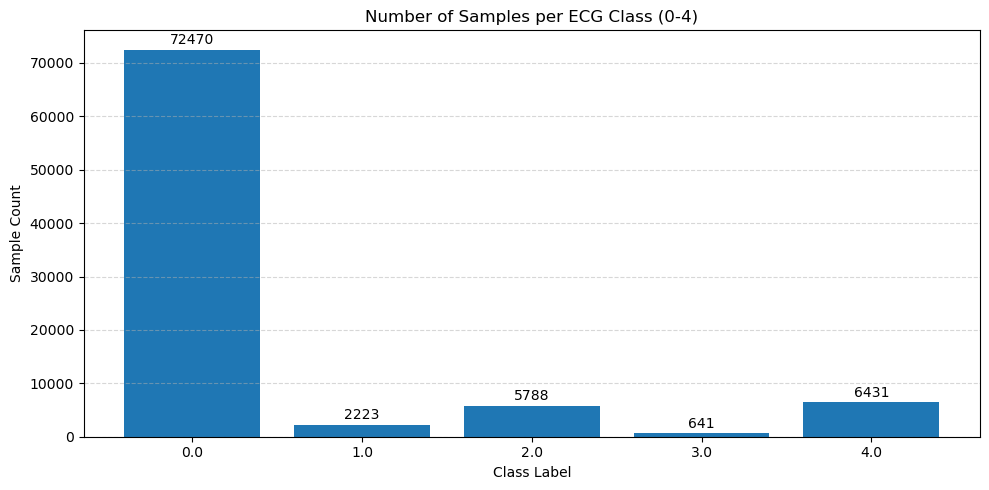

In [5]:
class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.index.astype(str), class_counts.values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 500,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title("Number of Samples per ECG Class (0-4)")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


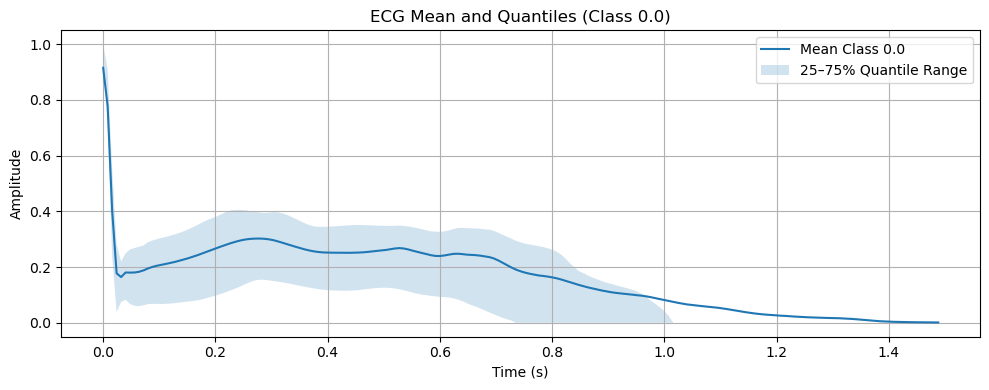

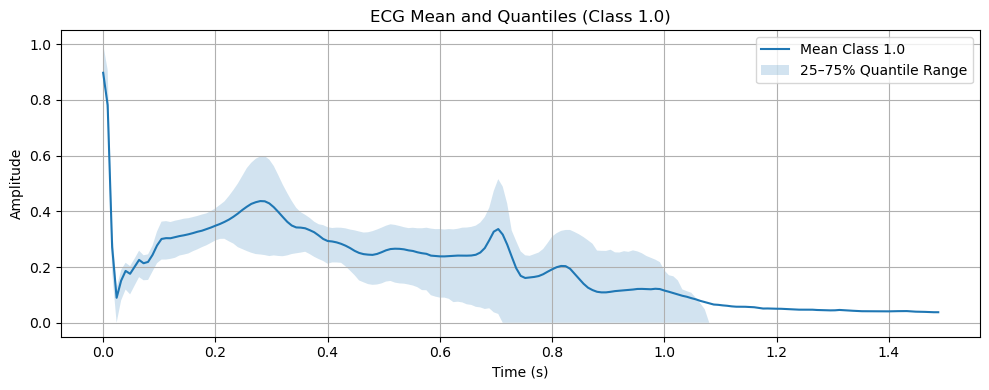

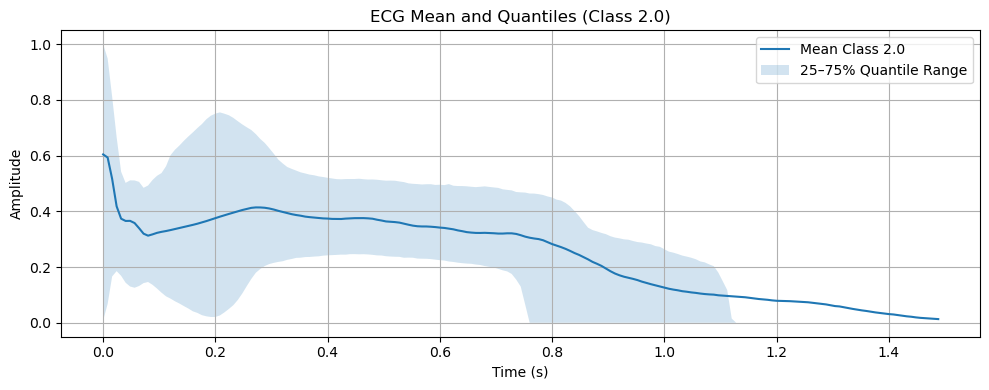

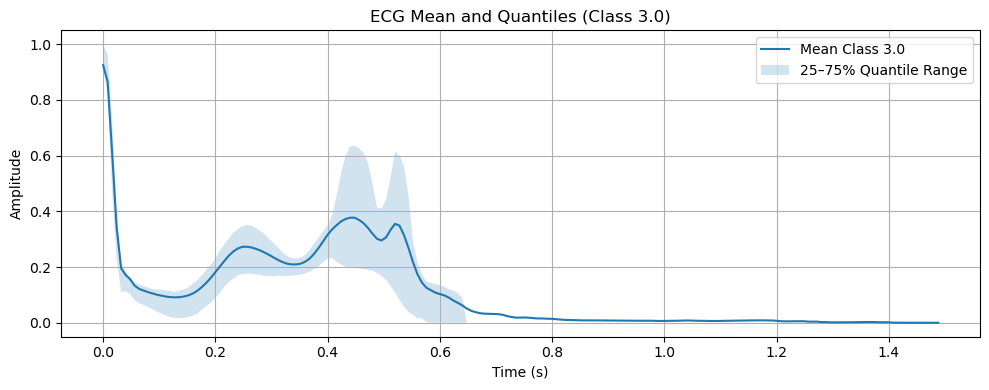

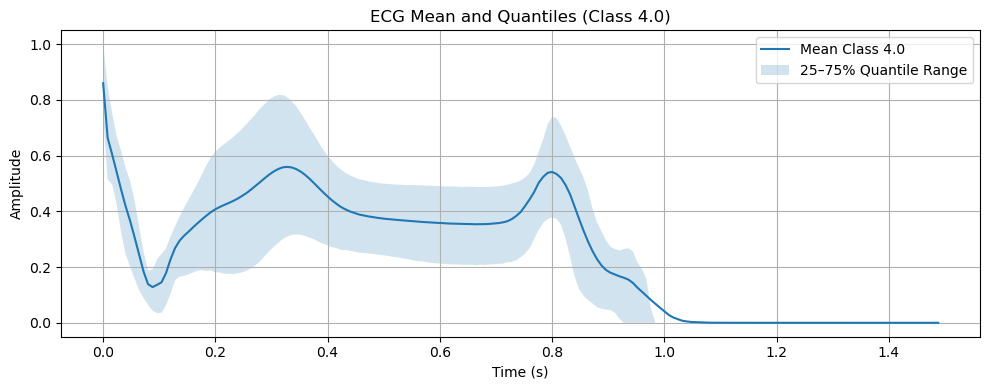

In [6]:
classes = sorted(y_train.unique())

lower_q = 0.25
upper_q = 0.75

for label in classes:
    class_samples = X_train_[y_train == label]
    
    mean_waveform = class_samples.mean(axis=0)
    lower_quantile = class_samples.quantile(lower_q, axis=0)
    upper_quantile = class_samples.quantile(upper_q, axis=0)
    
    t = np.arange(class_samples.shape[1]) / 125

    plt.figure(figsize=(10, 4))
    plt.plot(t, mean_waveform, label=f"Mean Class {label}")
    plt.fill_between(t, lower_quantile, upper_quantile, alpha=0.2,
                     label=f"{int(lower_q*100)}–{int(upper_q*100)}% Quantile Range")
    
    plt.title(f"ECG Mean and Quantiles (Class {label})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Resampling

In [7]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 10000}) 
over_sampler = SMOTETomek(sampling_strategy={1: 10000, 
                                        2: 10000, 
                                        3: 10000, 
                                        4: 10000})

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)


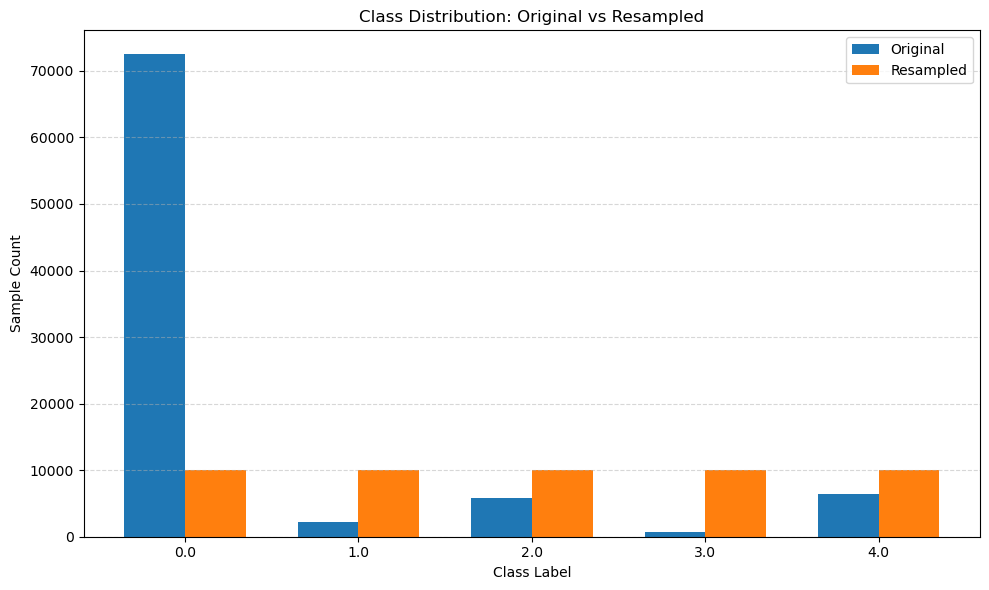

In [8]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## XGBOOST

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, make_scorer

In [10]:
def custom_weighted_recall(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
    weights = np.array([0.1, 1, 1, 1, 1])
    return np.sum(recalls * weights) / np.sum(weights)
    
weighted_recall_scorer = make_scorer(custom_weighted_recall, greater_is_better=True)

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 1000],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring= weighted_recall_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1
)

search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=5, n_estimators=300, subsample=0.6;, score=0.956 total time= 4.4min
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6;, score=0.970 total time=10.5min
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, subsample=1.0;, score=0.944 total time= 7.3min
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=5, n_estimators=300, subsample=1.0;, score=0.953 total time= 5.0min
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=1.0;, score=0.943 total time= 1.8min
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.960 total time=  58.0s
[CV 2/3] END colsamp

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=5, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 300, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring=make_scorer(custom_weighted_recall, response_method='predict'),
                   verbose=3)

In [12]:
search.best_params_

{'subsample': 1.0,
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.2,
 'colsample_bytree': 1.0}

In [16]:
xgb_model = search.best_estimator_

In [17]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9916    0.9652    0.9782     18117
         1.0     0.5591    0.8165    0.6637       556
         2.0     0.8930    0.9565    0.9236      1448
         3.0     0.5440    0.8395    0.6602       162
         4.0     0.9617    0.9826    0.9720      1608

    accuracy                         0.9612     21891
   macro avg     0.7899    0.9121    0.8396     21891
weighted avg     0.9686    0.9612    0.9638     21891



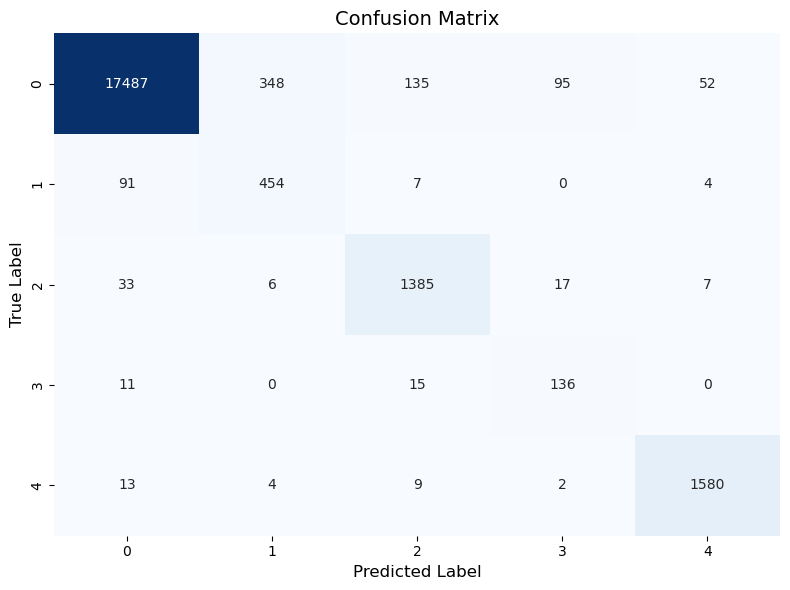

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [19]:
xgb_model.save_model('xgb_model.json')